Another attempt at Ensemble regression using a more recent example...

In [24]:
# IMPORTS
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')







In [2]:
# SPLITTING THE DATASET
target_path = '/kaggle/input/abalone/train.csv'
submission_path = '/kaggle/input/abalone/test.csv'

target = pd.read_csv(target_path)
submission = pd.read_csv(submission_path)

In [3]:
# One-hot encode 'Sex'
target = pd.get_dummies(target, columns=['Sex'], drop_first=True)
submission = pd.get_dummies(submission, columns=['Sex'], drop_first=True)

In [4]:
# View the updated dataset
target.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False


In [5]:
x = target.drop('Rings', axis = 1)
y = target['Rings']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [32]:
# MODELS CREATION
dtmodel = DecisionTreeRegressor()
knmodel = KNeighborsRegressor()
lrmodel= LinearRegression()

dtmodel.fit(x_train,y_train)
knmodel.fit(x_train,y_train)
lrmodel.fit(x_train,y_train)


LinearRegression()

In [33]:
# PREDICTION
pred1=dtmodel.predict(x_test)
pred2=knmodel.predict(x_test)
pred3=lrmodel.predict(x_test)


In [9]:
len(pred2)

18123

Note that previous versions of this code, which were using Classifiers, used LogisticRegression.  This is a classifier, not a regressor, despite its name.

In [34]:
models = [{"predictions": pred1, "model": dtmodel, "name": "Decision Tree"}, 
          {"predictions": pred2, "model": knmodel, "name": "K Neighbors"},
          {"predictions": pred3, "model": lrmodel, "name": "Linear Regression"},
         ]
models[0]

{'predictions': array([ 5.,  8.,  9., ..., 11.,  6.,  8.]),
 'model': DecisionTreeRegressor(),
 'name': 'Decision Tree'}

In [11]:
pred3[:20]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [35]:
def plot_predictions(models, sample_size=10):
    x = [n for n in range(sample_size)]

    plt.figure(figsize=(10, 6))

    # plot line
    for model in models:  
        plt.plot(x, model['predictions'][:sample_size], label=model['name'])

    plt.legend()
    plt.show()

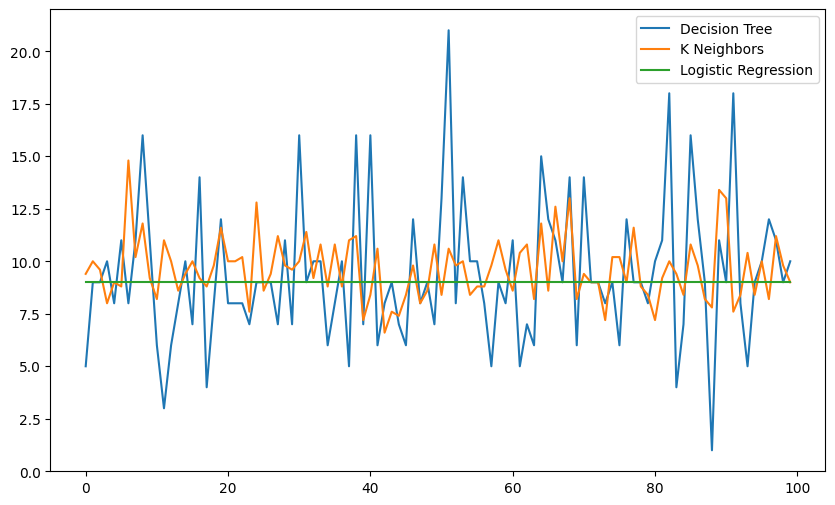

In [13]:
plot_predictions(models, 100)

In [36]:
# FINAL_PREDICTION
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
print(final_pred)

[ 5.  8.  9. ... 11.  6.  8.]


In [15]:
len(final_pred)

18123

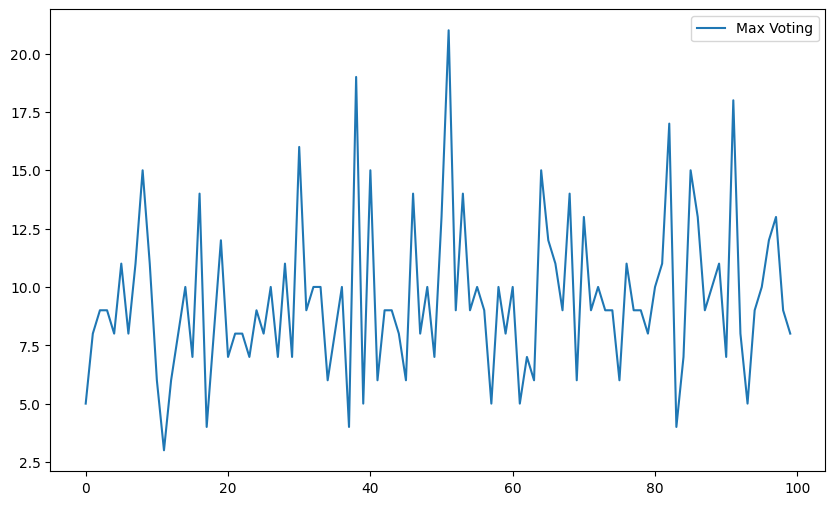

In [37]:
final_model1 = [{"predictions": final_pred, "name": "Max Voting"} ]
plot_predictions(final_model1, 100)

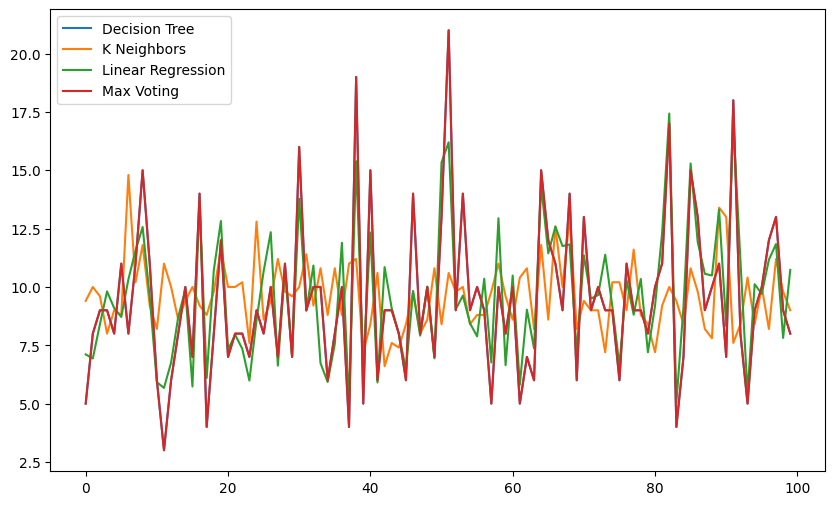

In [38]:
combo1 = models + final_model1
plot_predictions(combo1, 100)

In [18]:
models[0]['predictions']

array([ 5.,  9.,  9., ..., 11.,  6.,  8.])

In [39]:
from sklearn.ensemble import VotingRegressor


vcmodel = VotingRegressor(estimators=[('dt', models[0]["model"]), 
                                      ('kn', models[1]["model"]), 
                                      ('lr', models[2]["model"])])
vcmodel.fit(x_train,y_train)
vcmodel.score(x_test,y_test)

0.5148262113423039

Now trying averaging:

In [28]:
total = []
for model in models:
    pred = model['model'].predict_proba(x_test)
    if (len(total) == 0):
        total = pred
    else:
        total += pred


finalpreda=(total)/3

AttributeError: 'DecisionTreeRegressor' object has no attribute 'predict_proba'

Note how this does not really work, as the probabilities returned are a distribution, not a single value:
https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

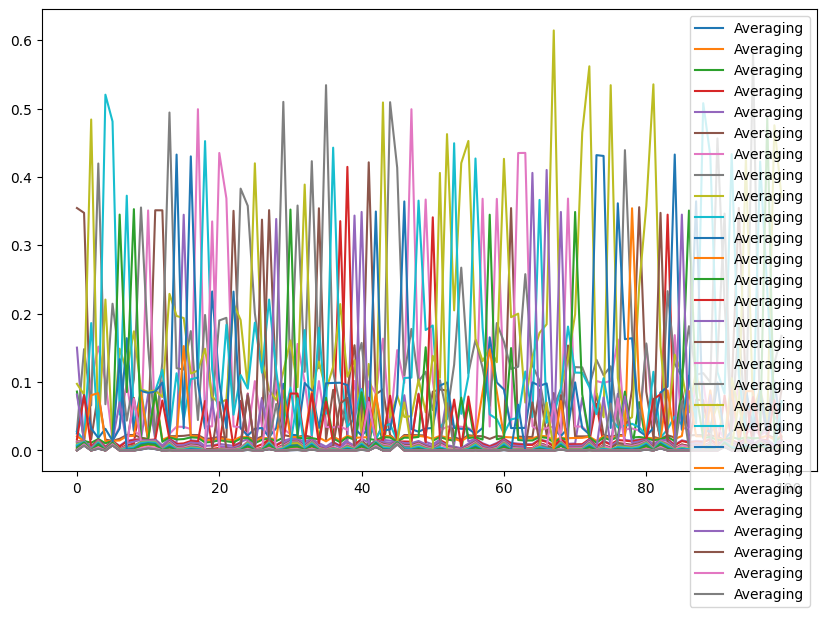

In [21]:
final_model1a = [{"predictions": finalpreda, "model": vcmodel, "name": "Averaging"} ]
plot_predictions(final_model1a, 100)

Introducing the evaluations and code used in my previous submission
https://github.com/flyinacres/kaggle/blob/main/abalone-submission-01.ipynb

In [40]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [50]:
def identify_negatives(predictions):
    n = [num for num in predictions if num < 0]
    print(n)

In [58]:
def ceil_predictions(predictions):
    return [0.0001 if num < 0 else num for num in predictions]


In [ ]:
# Need to ensure that results don't contain negative numbers or 0, or log will not work.
n = [0.0001 if num < 0 else num for num in models[2]['predictions']]
print(n)

In [59]:
from sklearn.metrics import r2_score

def evaluate_model(true, predicted):
    # mae = mean_absolute_error(true, predicted)
    # mse = mean_squared_error(true, predicted)
    # rmse = np.sqrt(mean_squared_error(true, predicted))
    predicted = ceil_predictions(predicted)
    r2_square = r2_score(true, predicted)
    rmsle = root_mean_squared_log_error(true, predicted)
    return r2_square,rmsle 

Pretty poor results as such...  Not worth submitting

In [60]:
for model in models:
    pred = model['model'].predict(x_test)
    print(evaluate_model(y_test, pred))

(0.28544772098503224, 0.21772592372610833)
(-0.16121687329383527, 0.3110966611528479)
(0.6107223774586408, 0.1651925987148862)


In [43]:
# See how well max voting stands up
print(evaluate_model(y_test, final_pred))

(0.28544772098503224, 0.21772592372610833)


Now try doing some feature engineering first...

In [ ]:
selected_features = ['Shell weight', 'Height', 'Diameter', 'Whole weight', 'Rings', 'Sex_I', 'Sex_M']